In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special


def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.2e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

rr = np.arange(12, 18, 1)
ee = [0]
em = [1]
atom = [13,20,32,50,79]
vran_0 = np.arange(200,2100,100)
# vran_1 = np.arange(1000,3000,500)
# vran = np.append(vran_0,vran_1)
vran = np.append(118,vran_0)

rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * atom / 10
total_N_c = total_N_c.flatten()

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm

C_IV_K_wo = 1548.187 # cm
C_IV_H_wo = 1550.772  # cm

cc = c.to(u.cm / u.s).value
v_th = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952


directory_1 = '~/RT/C_IV/code_tes/test_1e6/'

cc_k = c.to(u.km / u.s).value
V_K = 0
V_H = (C_IV_H/C_IV_K -1 ) * cc_k
def function(sigma,lam,lam_k,lam_h):
    tv_k = ((lam-lam_k) / lam_k ) * cc_k
    tv_h = ((lam-lam_h) / lam_h ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    return fx , f0

# plt.plot(del_V_space_g,yy_g)

3.39e+13


In [3]:
sigma_Lya, sigma_CIV, N_CIV_0 = CIV(1e5)
tau_0 = tau(sigma_CIV,total_N_c)
tau_0

array([3.83379483e-02, 5.89814589e-02, 9.43703342e-02, 1.47453647e-01,
       2.32976763e-01, 3.83379483e-01, 5.89814589e-01, 9.43703342e-01,
       1.47453647e+00, 2.32976763e+00, 3.83379483e+00, 5.89814589e+00,
       9.43703342e+00, 1.47453647e+01, 2.32976763e+01, 3.83379483e+01,
       5.89814589e+01, 9.43703342e+01, 1.47453647e+02, 2.32976763e+02,
       3.83379483e+02, 5.89814589e+02, 9.43703342e+02, 1.47453647e+03,
       2.32976763e+03, 3.83379483e+03, 5.89814589e+03, 9.43703342e+03,
       1.47453647e+04, 2.32976763e+04])

In [4]:
check = 0
for a , index in enumerate(rr):
    for b, expand in enumerate(ee):
        if expand == 10 :
            expand_v = 1
            num_ev = 2 
        elif expand == 0:
            expand_v = 0
            num_ev = 0
        else: 
            num_ev = 1
            expand_v = expand
        for c, vel in enumerate(vran):
            if vel < 1000 :
                 velr_v = vel
                 num_vr = 1
            else:
                velr_v = int(vel/10)
                num_vr = 2
            for d, atom_n in enumerate(atom):
                path_sp_1 = f'{directory_1}N_atom{atom_n}0E+{index}_Vexp{expand_v}00E+0{num_ev}_Vemit100E+00_tauD000E+00_Vran{velr_v}E+0{num_vr}spec_com.dat'         
                try:
                    data_sp_1 = pd.read_csv(path_sp_1, sep='\s+', header=None)
                except FileNotFoundError:
                    print(f"파일을 찾을 수 없습니다: {path_sp_1}")
                    check += 1
                    continue 

                
                sp_dlam_1 = data_sp_1[0].to_numpy()
                globals()[f'Lambda_{atom_n}_{index}_{expand}_{vel}'] =   sp_dlam_1
                sp_1 = data_sp_1[2].to_numpy()

                indices_K_1 = np.where(sp_dlam_1 <= 1550)[0]
                indices_H_1 = np.where(sp_dlam_1 > 1550)[0]

                sp_dlam_K = sp_dlam_1[indices_K_1]
                sp_dlam_H = sp_dlam_1[indices_H_1]

                dlam_k = sp_dlam_K[1]-sp_dlam_K[0]
                dlam_h = sp_dlam_H[1]-sp_dlam_H[0]
                dlam_sp =sp_dlam_1[1] -sp_dlam_1[0]
                # print(dlam_k ,dlam_h,dlam_sp)

                sp_K = sp_1[indices_K_1]
                sp_H = sp_1[indices_H_1]

                if len(sp_K) == 0 or len(sp_H) == 0:
                    print(f"데이터 부족: {path_sp_1}")
                    continue

                del_V_space = (sp_dlam_1 / C_IV_K_wo  - 1) * cc / 1e5  # km/s

                lam_c = (C_IV_H_wo+C_IV_K_wo) / 2
                # print(sep_point)
                indices_K_sp = np.where(sp_dlam_1 <= lam_c )[0]
                indices_H_sp = np.where(sp_dlam_1> lam_c)[0]

                int_Vel_K = del_V_space[indices_K_sp]
                int_Vel_H = del_V_space[indices_H_sp]

                int_flux_K = sp_1[indices_K_sp]
                int_flux_H = sp_1[indices_H_sp]

                delta_lam_K = sp_dlam_1[indices_K_sp]
                delta_lam_H = sp_dlam_1[indices_H_sp]
                globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{vel}'] = delta_lam_K
                globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{vel}'] = delta_lam_H  


                globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] = int_Vel_K 
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'] = int_flux_K

                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] = int_Vel_H  
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'] = int_flux_H           
print(check)  

파일을 찾을 수 없습니다: ~/RT/C_IV/code_tes/test_1e6/N_atom130E+12_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran200E+01spec_com.dat
파일을 찾을 수 없습니다: ~/RT/C_IV/code_tes/test_1e6/N_atom200E+12_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran200E+01spec_com.dat
파일을 찾을 수 없습니다: ~/RT/C_IV/code_tes/test_1e6/N_atom320E+12_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran200E+01spec_com.dat
파일을 찾을 수 없습니다: ~/RT/C_IV/code_tes/test_1e6/N_atom500E+12_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran200E+01spec_com.dat
파일을 찾을 수 없습니다: ~/RT/C_IV/code_tes/test_1e6/N_atom790E+12_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran200E+01spec_com.dat
파일을 찾을 수 없습니다: ~/RT/C_IV/code_tes/test_1e6/N_atom130E+12_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran300E+01spec_com.dat
파일을 찾을 수 없습니다: ~/RT/C_IV/code_tes/test_1e6/N_atom200E+12_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran300E+01spec_com.dat
파일을 찾을 수 없습니다: ~/RT/C_IV/code_tes/test_1e6/N_atom320E+12_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran300E+01spec_com.dat
파일을 찾을 수 없습니다: ~/RT/C_IV/code_tes/test_1e6/N_atom500E+12

In [5]:
def finding_FWHM_K(x, y,v_0):


    y_1_max = y.max()
    yc_1 = y_1_max / 2
    x_f_1 = []

    for ii in range(len(y) - 1):
        bb_1 = (y[ii] - yc_1) * (y[ii+1] - yc_1)    
        if bb_1 < 0:
            x_f_1.append(x[ii])

    if x_f_1 :
        # blue_w = abs(min(x_f_1) - x_1[np.argmax(y_1)])
        FWHM = abs(min(x_f_1) - v_0)
    else:
        FWHM = 0

    # print(yc_1, yc_2)
    return FWHM*2


def finding_FWHM_H(x, y,v_0):

    y_1_max = y.max()
    yc_1 = y_1_max / 2
    x_f_1 = []

    for ii in range(len(y) - 1):
        bb_1 = (y[ii] - yc_1) * (y[ii+1] - yc_1)    
        if bb_1 < 0:
            x_f_1.append(x[ii])

    if x_f_1 :
        # blue_w = abs(min(x_f_1) - x_1[np.argmax(y_1)])
        FWHM = abs(min(x_f_1) - v_0)
    else:
        FWHM = 0

    # print(yc_1, yc_2)
    return FWHM*2

0.11604620768160546
--------------------------------------------------
K line  FWHM is  38.80565369891275
H line  FWHM is  31.13747063261428
--------------------------------------------------


,Random Velocity [km/s],K line FWHM [km/s],H line FWHM [km/s]
0,11.8,38.8,31.1


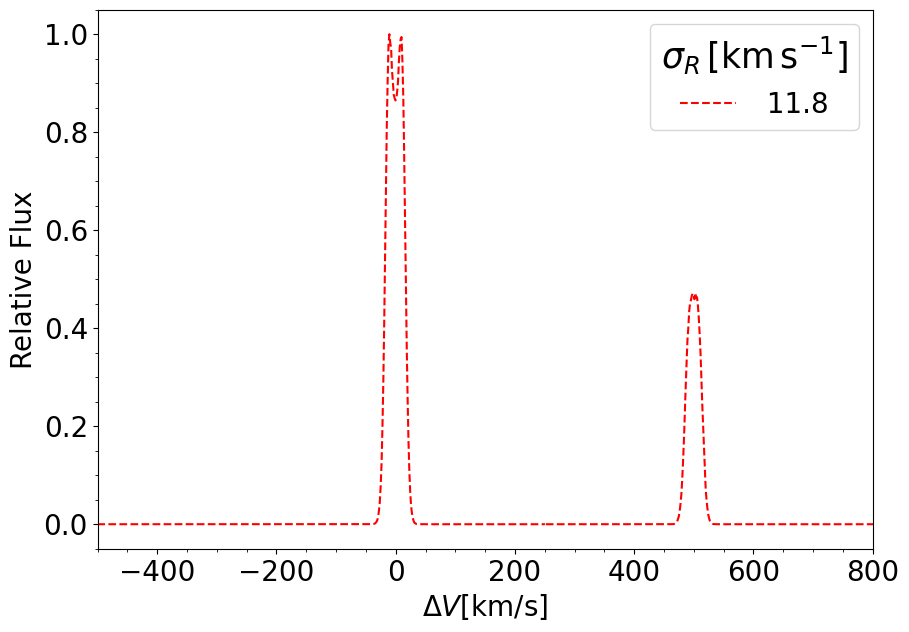

In [6]:
fig = plt.figure(1,figsize=(10,7))

atom_n,index, expand = 79,13,0
vel = 118

normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'])

plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}']/normal,'r--',label=f' {vel/10}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}']/normal,'r--')
# plt.scatter(-35.45566463209831,2752.5/normal,color='r',s=30)
print(2752.5/normal)
FWHM_K = finding_FWHM_K(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
FWHM_H = finding_FWHM_H(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H)
print('-'*50)
print('K line  FWHM is ', FWHM_K)
print('H line  FWHM is ', FWHM_H)
print('-'*50)
data = {
        'Random Velocity [km/s]': [np.round(vel/10,1)],
        'K line FWHM [km/s]': [np.round(FWHM_K,1)],
        'H line FWHM [km/s]': [np.round(FWHM_H,1)]
    }
df = pd.DataFrame(data)

plt.xlabel(r'$\Delta V [\rm km/s]$', fontsize= 20)
plt.ylabel('Relative Flux',fontsize=20)
plt.minorticks_on()
plt.xlim(-500,800)
plt.legend(title=r'$\sigma_R \, [\rm km \, s^{-1}]$', fontsize=20, title_fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig(r'/home/jin/바탕화면/various_random_Velocity.pdf',bbox_inches='tight')
df


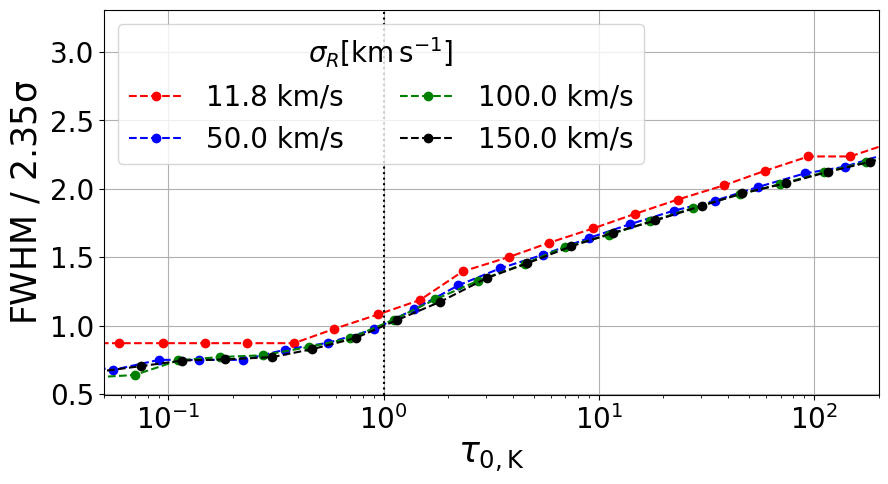

In [7]:
# atom_n,index, expand = 32,13,0
vel_0 = 118

vel = 118
import math
blue_K = np.zeros(len(total_N_c))
red_K = np.copy(blue_K)
blue_H = np.copy(blue_K)
red_H = np.copy(blue_K)

K_FWHM = np.copy(blue_K)
H_FWHM = np.copy(blue_K)
T_FWHM = np.copy(blue_K)
for ii, N_civ in enumerate(total_N_c):
    index = math.floor(math.log10(N_civ))
    atom_n = int(N_civ/ 10**index * 10)
    K_FWHM[ii] = finding_FWHM_K(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
    H_FWHM[ii]  = finding_FWHM_H(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H) 

fig = plt.figure(1,figsize=(10,5))

plt.plot(tau_0/(vel/vel_0),K_FWHM /vel*10/(2*np.sqrt(2*np.log(2))) ,'ro--',label=f'{vel/10} km/s')

vel = 500
import math
blue_K = np.zeros(len(total_N_c))
red_K = np.copy(blue_K)
blue_H = np.copy(blue_K)
red_H = np.copy(blue_K)

K_FWHM = np.copy(blue_K)
H_FWHM = np.copy(blue_K)
T_FWHM = np.copy(blue_K)
for ii, N_civ in enumerate(total_N_c):
    index = math.floor(math.log10(N_civ))
    atom_n = int(N_civ/ 10**index * 10)
    K_FWHM[ii] = finding_FWHM_K(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
    H_FWHM[ii]  = finding_FWHM_H(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H) 

fig = plt.figure(1,figsize=(10,5))



plt.plot(tau_0/(vel/vel_0),K_FWHM /vel*10/(2*np.sqrt(2*np.log(2))) ,'bo--',label=f'{vel/10} km/s')




vel = 1000
import math
blue_K = np.zeros(len(total_N_c))
red_K = np.copy(blue_K)
blue_H = np.copy(blue_K)
red_H = np.copy(blue_K)

K_FWHM = np.copy(blue_K)
H_FWHM = np.copy(blue_K)
T_FWHM = np.copy(blue_K)
for ii, N_civ in enumerate(total_N_c):
    index = math.floor(math.log10(N_civ))
    atom_n = int(N_civ/ 10**index * 10)
    K_FWHM[ii] = finding_FWHM_K(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
    H_FWHM[ii]  = finding_FWHM_H(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H) 



plt.plot(tau_0/(vel/vel_0),K_FWHM /vel*10/(2*np.sqrt(2*np.log(2))) ,'go--',label=f'{vel/10} km/s')


vel = 1500
import math
blue_K = np.zeros(len(total_N_c))
red_K = np.copy(blue_K)
blue_H = np.copy(blue_K)
red_H = np.copy(blue_K)

K_FWHM = np.copy(blue_K)
H_FWHM = np.copy(blue_K)
T_FWHM = np.copy(blue_K)
for ii, N_civ in enumerate(total_N_c):
    index = math.floor(math.log10(N_civ))
    atom_n = int(N_civ/ 10**index * 10)
    K_FWHM[ii] = finding_FWHM_K(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],V_K)
    H_FWHM[ii]  = finding_FWHM_H(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{vel}'],V_H) 



plt.plot(tau_0/(vel/vel_0),K_FWHM /vel*10/(2*np.sqrt(2*np.log(2)))  ,'ko--',label=f'{vel/10} km/s')

# plt.plot(total_N_c,H_FWHM,'ro-',label='H line')
plt.xscale('log')
plt.axvline(x=1,ymin=0,ymax=5,color='k',linestyle=':')
plt.xlabel(r'$\tau_{0,\rm K}$',fontsize=25)
plt.ylabel(r'$ \rm {FWHM} ~/~ {2.35 \sigma}$',fontsize=25)
plt.legend(fontsize=20,ncol=2,title=f'$\sigma_{{R}} = {vel/10} ~~ [\\rm km \\, s^{{-1}}] $',title_fontsize=25)
plt.xlim(0.05,2e2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(loc='upper left',fontsize = 20,ncol=2,title = r'$\sigma_R [\rm km \, s^{-1}]$',title_fontsize=20)




# plt.savefig(r'/home/jin/바탕화면/column_density_FWHM.pdf',bbox_inches='tight')

(-250.0, 250.0)

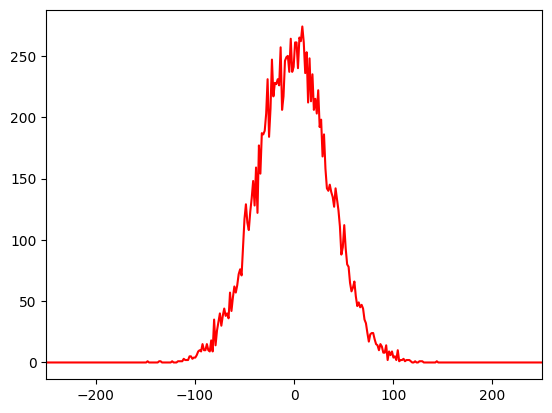

In [8]:
vel = 500
atom_n = 32
index = 12

plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{vel}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{vel}'],'r-')
plt.xlim(-250,250)